In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve, 
    auc, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb 
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings('ignore')

#Balance methods 
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.combine import SMOTETomek, SMOTEENN

#Grafics_style 
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [7]:
df = pd.read_csv("./Dataset.csv")
df.head()

,PIPE_NO,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
0,PP22033000042,318,7798,365,7177,9507,1
1,PP22033000042,318,7798,365,7177,9507,1
2,PP22033000042,316,8479,380,8846,9484,1
3,PP22033000042,316,8479,380,8846,9484,1
4,PP22033000042,309,7603,351,5726,9840,1


In [8]:
# Information about data structure
df.dtypes

PIPE_NO     object
DV_R         int64
DA_R         int64
AV_R         int64
AA_R         int64
PM_R         int64
FIN_JGMT     int64
dtype: object

| Column | Значение |Meaning| Note|
|---------|----------|------------|------------|
| PIPE_NO | Серийный номер трубы | Pipe serial number | string |
| DV_R | Напряжение правой стороны | Right side voltage | int |
| DA_R | Ток правой стороны | Right side current | int |
| AV_R | Среднее напряжение | Medium voltage | int |
| AA_R | Средний ток | Average current | int |
| PM_R | Код режима сварки | Welding mode code | int |
| FIN_JGMT | FIN_JGMT=1: норма(normal) | FIN_JGMT=0: дефект(defect) | int |

In [9]:
df.describe()

,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
count,739888.000000,739888.000000,739888.000000,739888.000000,7.398880e+05,739888.000000
mean,326.640292,6890.474566,376.151258,5760.547448,9.609554e+03,0.846198
std,254.756693,1340.889458,455.283380,758.968542,8.761484e+04,0.360759
min,1.000000,1.000000,11.000000,1.000000,2.000000e+00,0.000000
25%,309.000000,6156.000000,341.000000,5631.000000,9.285000e+03,1.000000
50%,310.000000,6979.000000,349.000000,5818.000000,9.569000e+03,1.000000
75%,316.000000,7857.000000,354.000000,5993.000000,9.832000e+03,1.000000
max,12680.000000,13701.000000,10984.000000,78935.000000,5.076137e+07,1.000000


In [10]:
# check for missing values
df.isnull().sum()

PIPE_NO     0
DV_R        0
DA_R        0
AV_R        0
AA_R        0
PM_R        0
FIN_JGMT    0
dtype: int64

In [11]:
# Class distribution (imbalance)

class_counts = df['FIN_JGMT'].value_counts()
display(class_counts)
print(f"Class ratio (normal:defect): {class_counts[1]/class_counts[0]:.2f}:1")

FIN_JGMT
1    626092
0    113796
Name: count, dtype: int64

Class ratio (normal:defect): 5.50:1


#### <span style="color:green">Visualization of class distribution

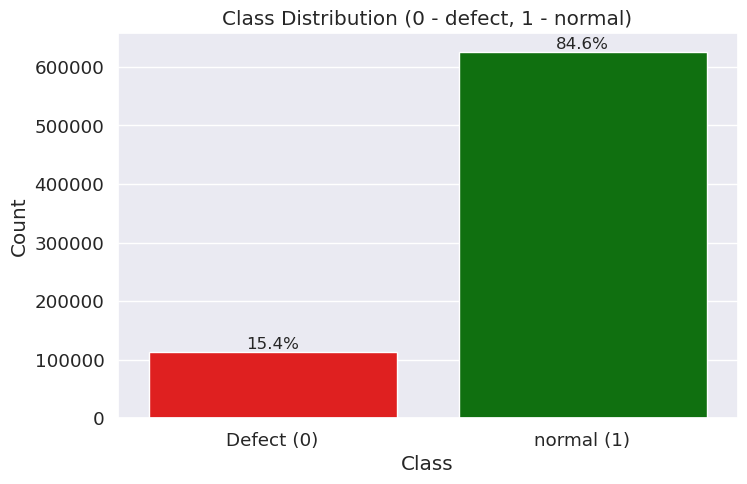

In [12]:
plt.figure(figsize=[8, 5])
ax = sns.countplot(x='FIN_JGMT', data=df, palette=['red', 'green'])
plt.title("Class Distribution (0 - defect, 1 - normal)")
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Defect (0)', 'normal (1)'])


total = len(df) 
for p in ax.patches: 
    height = p.get_height() 
    percentage = 100 * height / total 
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha = 'center',
                va = 'bottom', 
                fontsize=12
                )

plt.show()

### <span style='color:green'> Data Quality Analysis

In [13]:
# 1.1 Data Completeness
completeness = (1 - (df.isnull().sum() / len(df))) * 100
display(completeness)

PIPE_NO     100.0
DV_R        100.0
DA_R        100.0
AV_R        100.0
AA_R        100.0
PM_R        100.0
FIN_JGMT    100.0
dtype: float64

#### <span style="color:red">As we can see, there are no empty values in our dataset.Our Dataset does not have missing values this was also checked earlier

In [14]:
#1.2 Data Unique 
uniqueness = {}
for col in df.columns: 
    uniqueness[col] = (df[col].nunique() / len(df)) * 100
display(pd.Series(uniqueness))

PIPE_NO     0.040952
DV_R        0.150428
DA_R        0.670642
AV_R        0.201652
AA_R        0.563058
PM_R        0.730651
FIN_JGMT    0.000270
dtype: float64

### <span style='color:red'>Outliers detection

#### with IQR

In [15]:
outliers_info = {} 
for col in ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']: 
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    outliers_info[col] = {
        'total_outliers': len(outliers), 
        'percentage': (len(outliers) / len(df)) * 100, 
        'min_value': df[col].min(), 
        'max_value': df[col].max(), 
        'lower_bound': lower_bound, 
        'upper_bound': upper_bound
    }

In [16]:
# Info about outliers 

outliers_df = pd.DataFrame(outliers_info).T 
outliers_df['total_outliers'] = outliers_df['total_outliers'].astype(int)
outliers_df['percentage'] = outliers_df['percentage'].round(2)
display(outliers_df)

,total_outliers,percentage,min_value,max_value,lower_bound,upper_bound
DV_R,26430,3.57,1.0,12680.0,298.5,326.5
DA_R,13140,1.78,1.0,13701.0,3604.5,10408.5
AV_R,40470,5.47,11.0,10984.0,321.5,373.5
AA_R,58510,7.91,1.0,78935.0,5088.0,6536.0
PM_R,103910,14.04,2.0,50761372.0,8464.5,10652.5


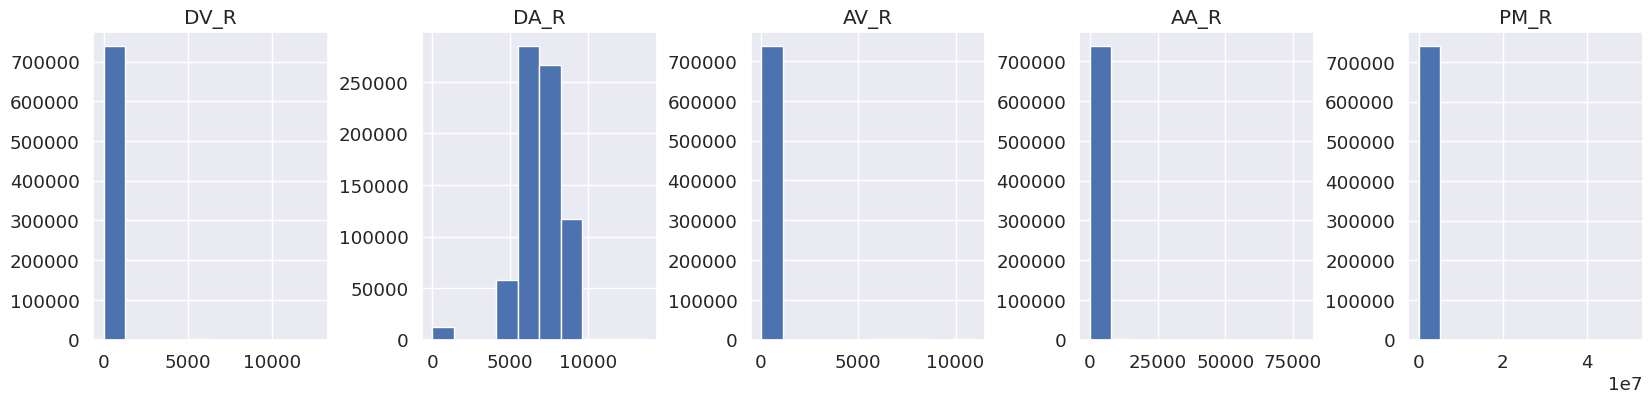

In [17]:
# Add gistogram 
vars_list=['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R'] 

plt.figure(figsize=[20, 4])
for i, col in enumerate(vars_list): 
    plt.subplot(1, 5, i + 1)
    n, bins, patches = plt.hist(df[col], bins = 10)
    plt.title(col)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

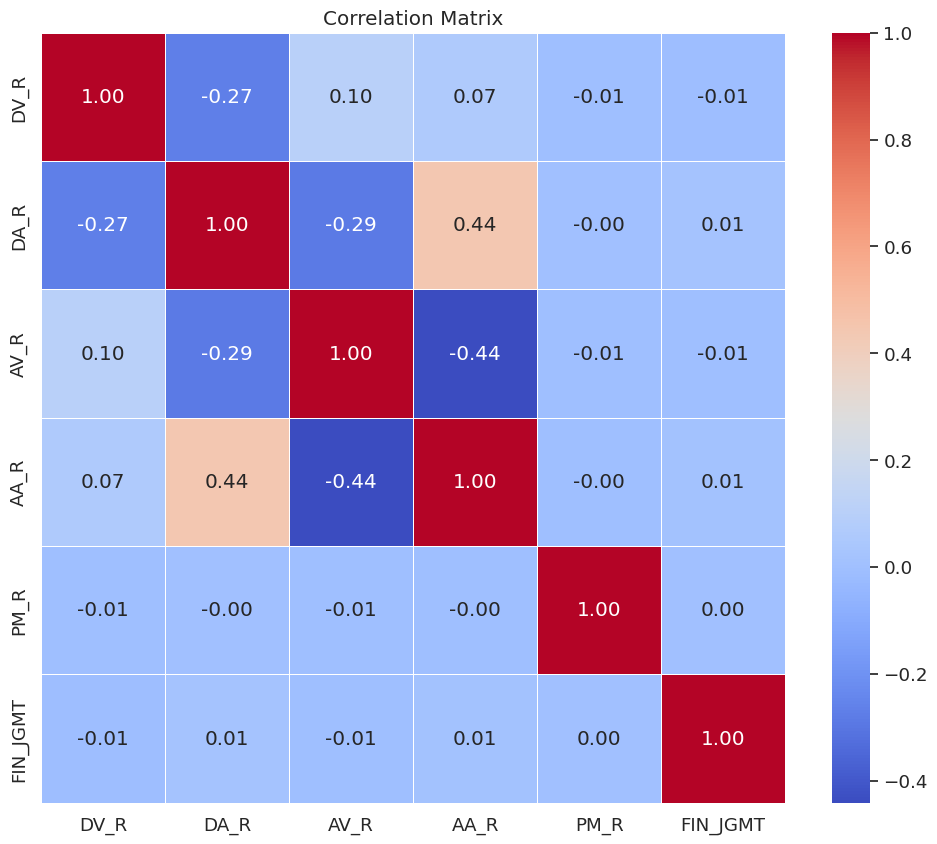

In [18]:
# Corr Analysis
corr = df[['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R', 'FIN_JGMT']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr,annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [19]:
X = df[['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']]
y = df['FIN_JGMT']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0, 
    stratify=y
)

X_train.shape, X_test.shape

((591910, 5), (147978, 5))

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, QuantileTransformer 
from sklearn.pipeline import Pipeline

In [22]:
normalizers = {
    'StandardScaler': StandardScaler(), 
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(), 
    'Normalizer': Normalizer(), 
    'QuantileTranformer': QuantileTransformer(output_distribution='normal')
}

In [23]:
scaled_data={}

In [24]:
for name, normalizer in normalizers.items(): 
    X_train_normalized = normalizer.fit_transform(X_train)
    X_test_normalized = normalizer.transform(X_test)

    # Save normalize data 
    scaled_data[name] = {
        'X_train': X_train_normalized, 
        'X_test': X_test_normalized, 
        'normalizer': normalizer
    }
    print(f"Applied {name}")

Applied StandardScaler
Applied MinMaxScaler
Applied RobustScaler
Applied Normalizer
Applied QuantileTranformer


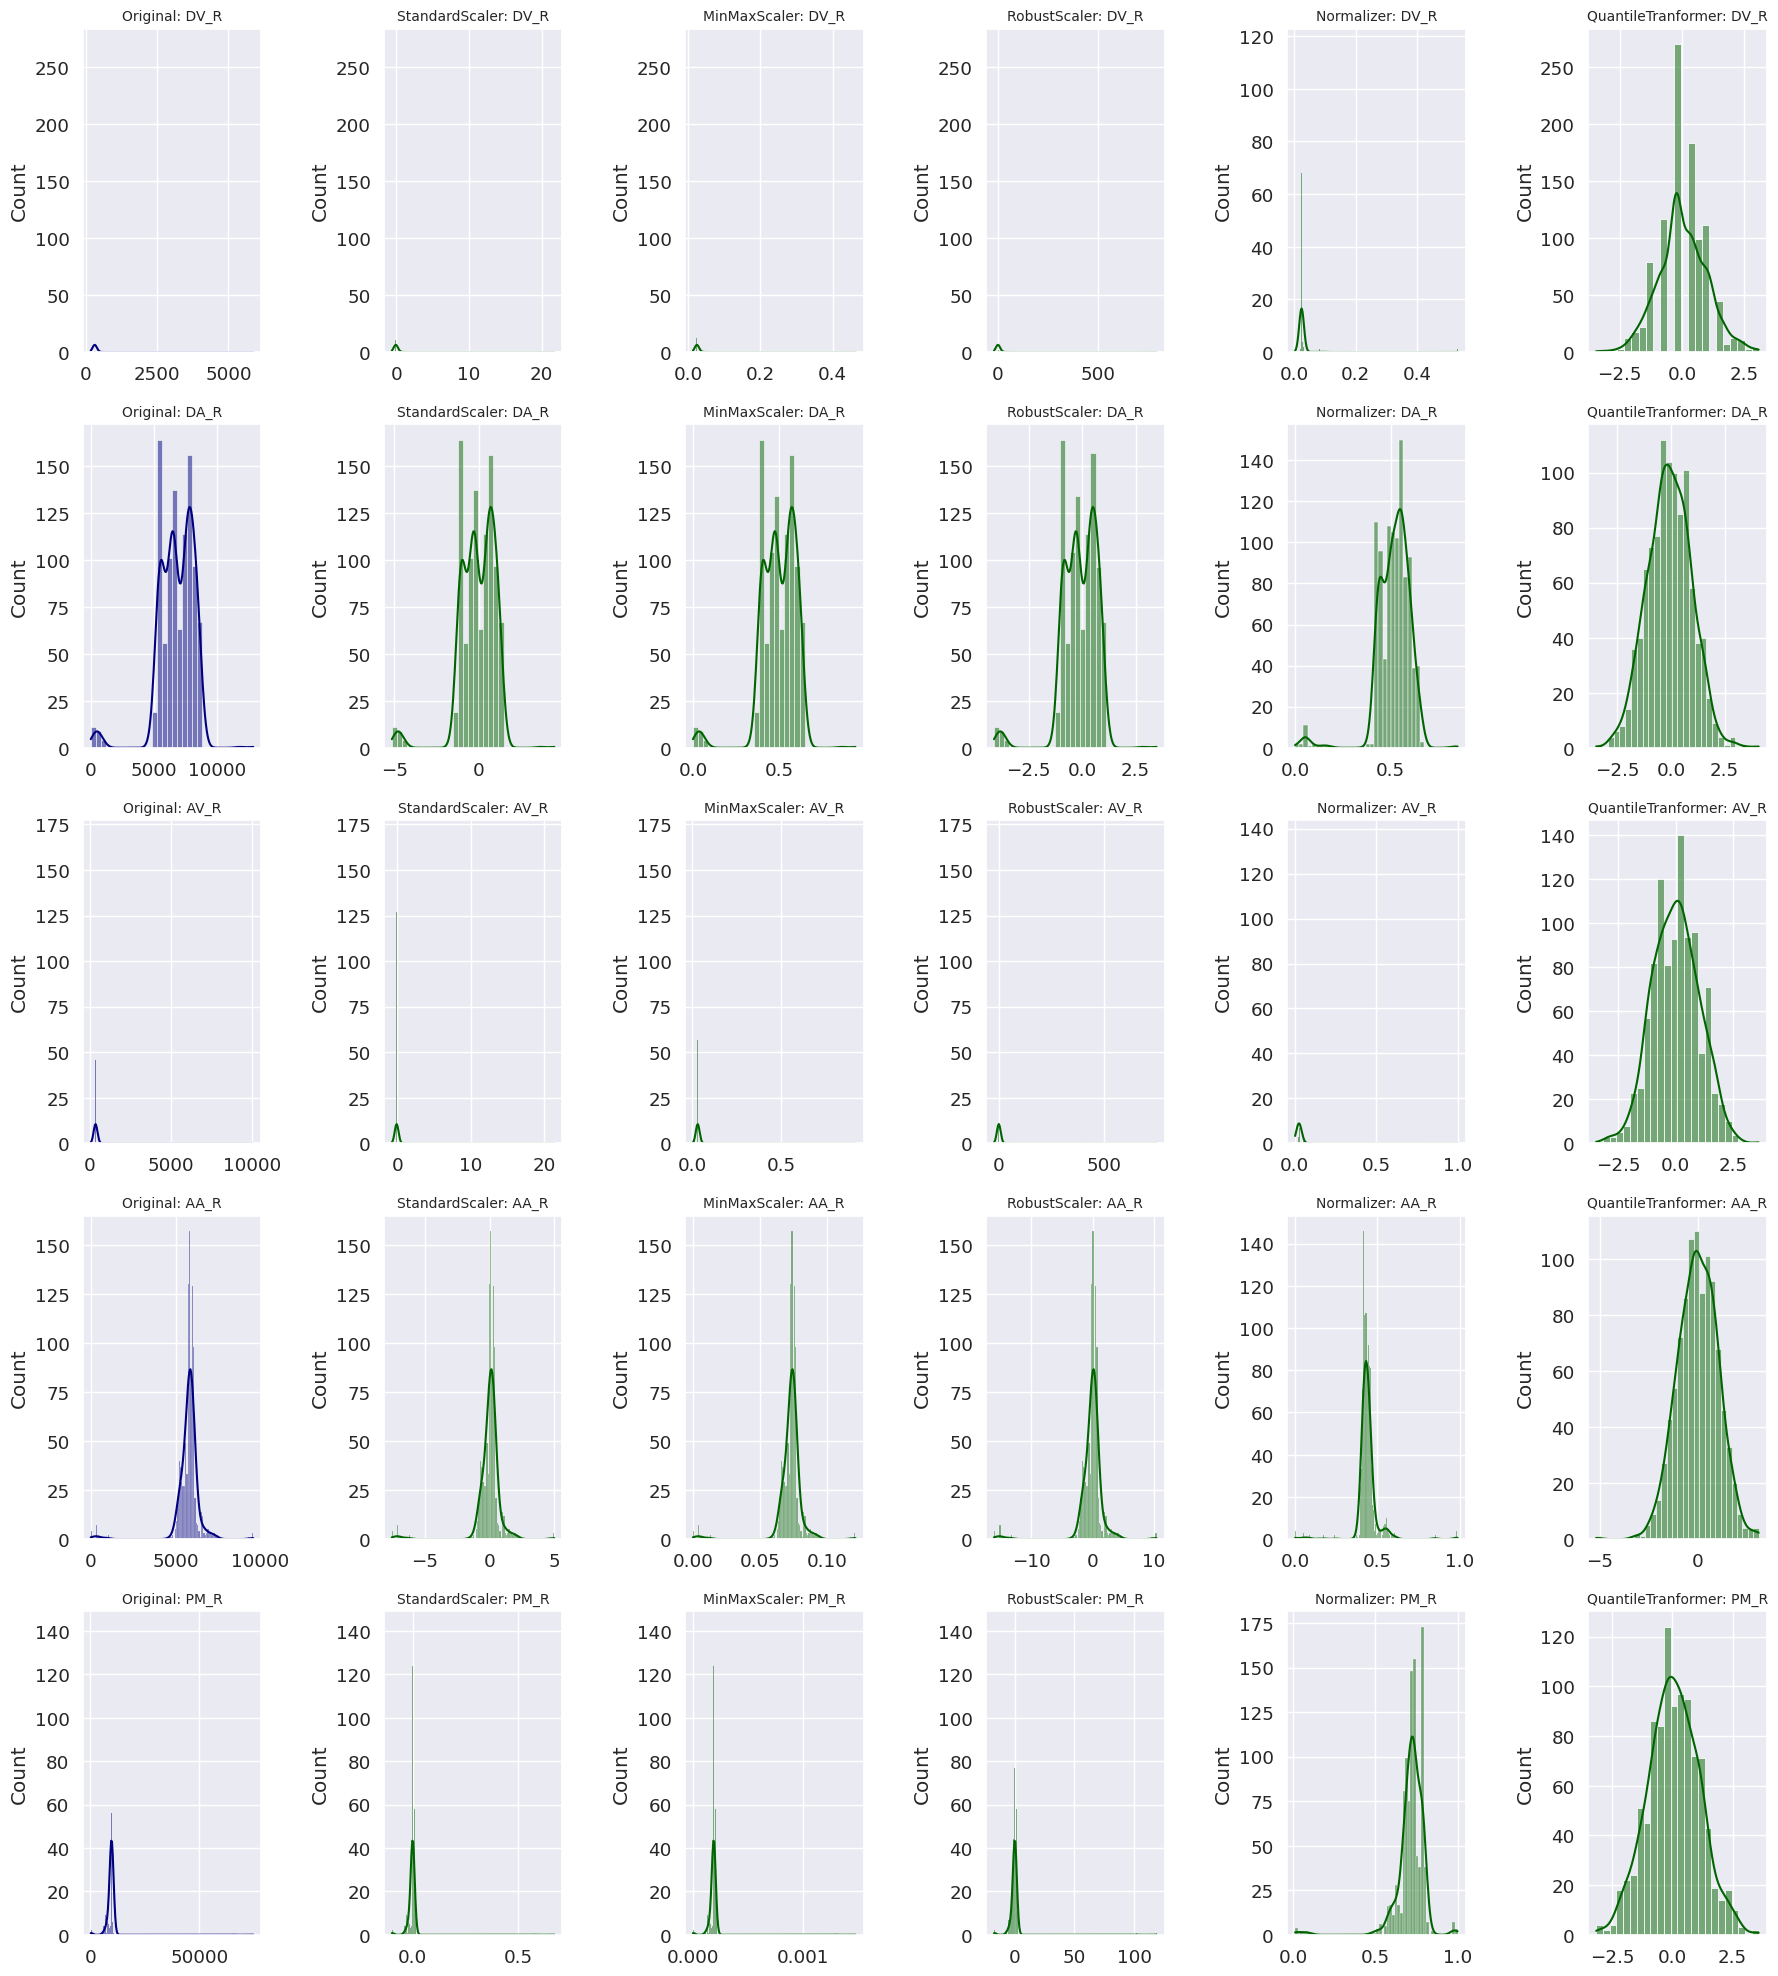

In [25]:
sample_size = min(1000, len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)

# create figure 
n_features = X_train.shape[1]
n_normalizers = len(normalizers) + 1 #for original data
fig_height = 4 * n_features
fig_width = 3 * n_normalizers
plt.figure(figsize=(fig_width, fig_height))

# visual
for i, feature_idx in enumerate(range(X_train.shape[1])): 
    feature_name = X.columns[feature_idx]

    plt.subplot(n_features, n_normalizers, i * n_normalizers + 1)
    sns.histplot(X_train.iloc[sample_indices, feature_idx], kde=True, color = 'navy')
    plt.title(f'Original: {feature_name}', fontsize=10)
    plt.xlabel('')
    # normolize data 
    for j, (name, data) in enumerate(scaled_data.items()): 
        plt.subplot(n_features, n_normalizers, i* n_normalizers + j + 2)
        sns.histplot(data['X_train'][sample_indices, feature_idx], kde=True, color='darkgreen')
        plt.title(f'{name}: {feature_name}', fontsize=10)
        plt.xlabel('')

plt.tight_layout()
plt.show()

In the graphs above we see that almost all methods work the same way, maybe some values will be a little higher


 Comparing normalization methods using baseline model:
StandardScaler: Accuracy = 0.8462
MinMaxScaler: Accuracy = 0.8462
RobustScaler: Accuracy = 0.8462
Normalizer: Accuracy = 0.8462
QuantileTranformer: Accuracy = 0.8453


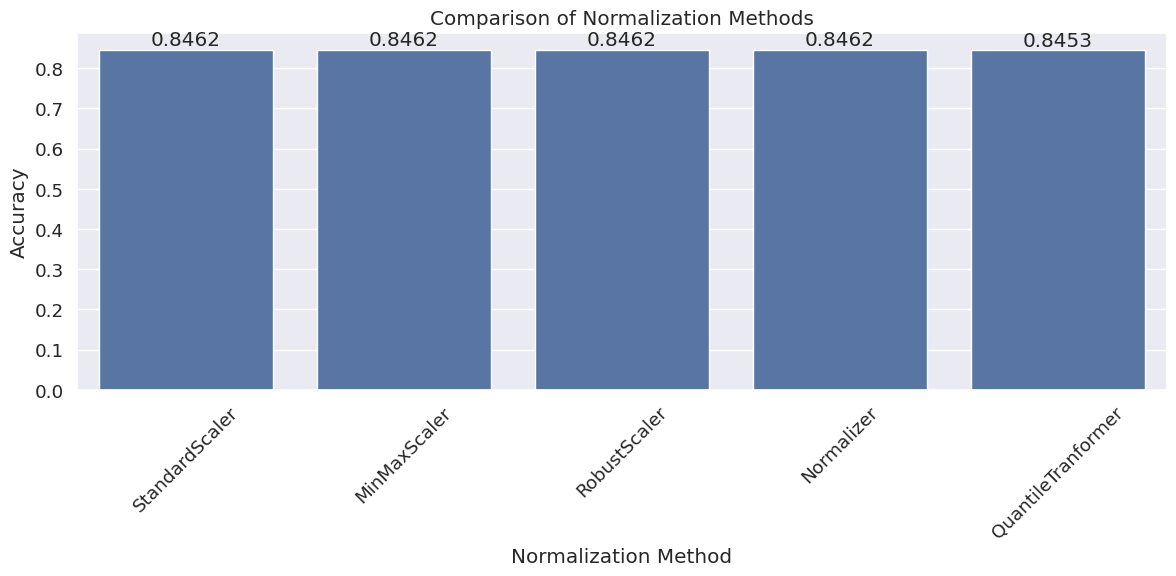

In [26]:
print("\n Comparing normalization methods using baseline model:")

normalization_results = {} 

for name, data in scaled_data.items(): 
    model = LogisticRegression(random_state=0, max_iter=1000, C=1.0, solver='liblinear')
    model.fit(data['X_train'], y_train)

    y_pred = model.predict(data['X_test'])
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    normalization_results[name] = {
        'accuracy': accuracy, 
        'report': report, 
        'model': model
    }

    print(f"{name}: Accuracy = {accuracy:.4f}")

# Visualization of comparison of normalization methods 
plt.figure(figsize=[12, 6])
accuracies =[result['accuracy'] for result in normalization_results.values()]
method_names = list(normalization_results.keys())

sns.barplot(x=method_names, y=accuracies)
plt.title('Comparison of Normalization Methods')
plt.xlabel("Normalization Method")
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Adding Precision Values
for i, acc in enumerate(accuracies): 
    plt.text (i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

Yes, as we saw earlier, all methods worked almost identically, not counting the quantel transformer. Well, in principle, this is not so critical

In [27]:
best_method = max(normalization_results.items(), key = lambda x: x[1]['accuracy'])[0]
best_normalizer = scaled_data[best_method]['normalizer']
X_train_scaled = scaled_data[best_method]['X_train']
X_test_scaled = scaled_data[best_method]['X_test']

print(f"\nBest normalization method: {best_method} with accuracy {normalization_results[best_method]['accuracy']:.4f}")
print("Using this method for further analysis")


Best normalization method: StandardScaler with accuracy 0.8462
Using this method for further analysis


In [28]:
# Continue with StandardScaler
print(f'Training set size: {X_train.shape[0]} rows')
print(f"Test set size: {X_test.shape[0]} rows")
print(f"\nClass distribution in training set: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Class distribution in test set: {pd.Series(y_test).value_counts().to_dict()}")

Training set size: 591910 rows
Test set size: 147978 rows

Class distribution in training set: {1: 500873, 0: 91037}
Class distribution in test set: {1: 125219, 0: 22759}


### <span style='color:red'>Yes I want to build a baseline module using Standard scaler and using weights

### Baseline Model (Before balancing)

#### Training and evaluating baseline model on imbalanced data

In [29]:
minor_weight = 5
major_weight = 1

In [30]:
baseline_model = LogisticRegression(random_state=42, 
                                   max_iter=1000, 
                                   C=1.0,
                                    solver='liblinear', 
                                   class_weight={0: minor_weight, 1: major_weight})
print(f"Baseline model with class weigh: minor={minor_weight}, major={major_weight}")
baseline_model.fit(X_train_scaled, y_train)

Baseline model with class weigh: minor=5, major=1


LogisticRegression(class_weight={0: 5, 1: 1}, max_iter=1000, random_state=42,
                   solver='liblinear')

In [31]:
y_pred_baseline = baseline_model.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_report = classification_report(y_test, y_pred_baseline, output_dict=True)
baseline_conf_matrix = confusion_matrix(y_test, y_pred_baseline)

In [32]:
y_test_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_proba)

In [33]:
# Trainset scoring
train_pred = baseline_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)
train_report = classification_report(y_train, train_pred, output_dict=True)

In [34]:
# Trainset ROC-AUC
train_proba = baseline_model.predict_proba(X_train_scaled)[:, 1]
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

In [35]:
print(f"\nTestset results:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"F1 (class 0): {baseline_report['0']['f1-score']:.4f}")
print(f"F1 (class 1): {baseline_report['1']['f1-score']:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")


Testset results:
Accuracy: 0.8191
F1 (class 0): 0.0999
F1 (class 1): 0.8994
ROC-AUC: 0.5880


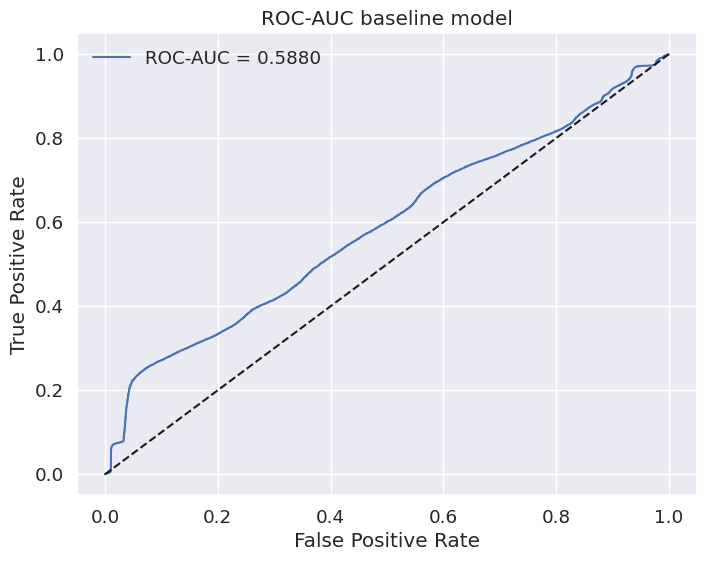

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {test_roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC baseline model')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# result comparison Train and Test
results_comparison = pd.DataFrame({
    "Metrics" : ['Accuracy', 'F1 (class 0)', 'F1 (class 1)', 'ROC-AUC'],
    'Trainset' : [train_accuracy, train_report['0']['f1-score'], 
                 train_report['1']['f1-score'], train_roc_auc], 
    'Testset' : [baseline_accuracy, baseline_report['0']['f1-score'], 
                baseline_report['1']['f1-score'], test_roc_auc]
})

In [38]:
print("\nTrainset nd Testset results:")
print(results_comparison)


Trainset nd Testset results:
        Metrics  Trainset   Testset
0      Accuracy  0.818913  0.819088
1  F1 (class 0)  0.099110  0.099923
2  F1 (class 1)  0.899340  0.899438
3       ROC-AUC  0.585618  0.588015


<Figure size 1000x600 with 0 Axes>

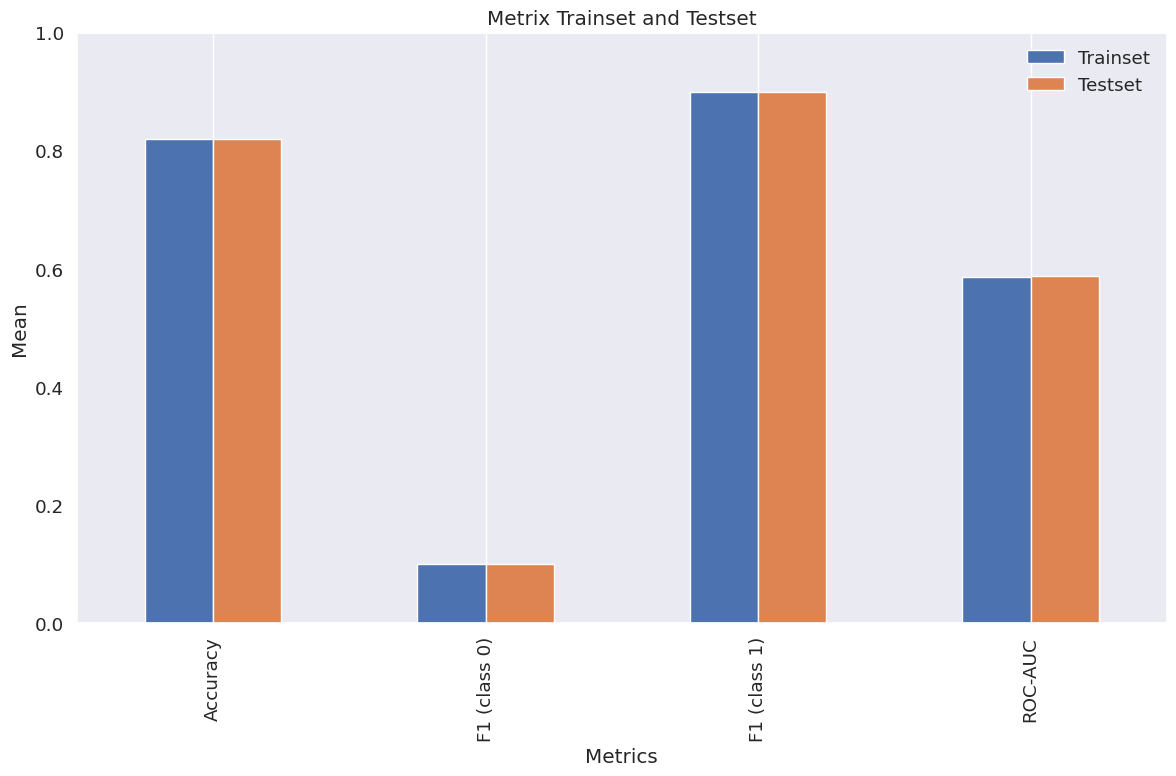

In [39]:
plt.figure(figsize=(10, 6))
results_comparison.set_index('Metrics').plot(kind='bar')
plt.title('Metrix Trainset and Testset')
plt.ylabel('Mean')
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.legend(title='')
plt.tight_layout()
plt.show()

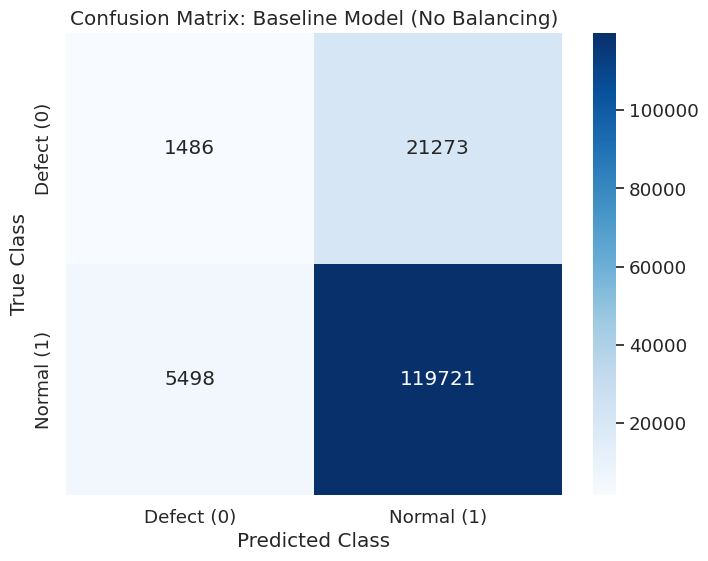

In [40]:
# Visualization of confusion matrix for baseline model
plt.figure(figsize=(8, 6))
sns.heatmap(baseline_conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Defect (0)', 'Normal (1)'],
           yticklabels=['Defect (0)', 'Normal (1)'])
plt.title('Confusion Matrix: Baseline Model (No Balancing)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [41]:
y_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)


# PR curve for baseline model
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_proba_baseline)
pr_auc_baseline = average_precision_score(y_test, y_proba_baseline)

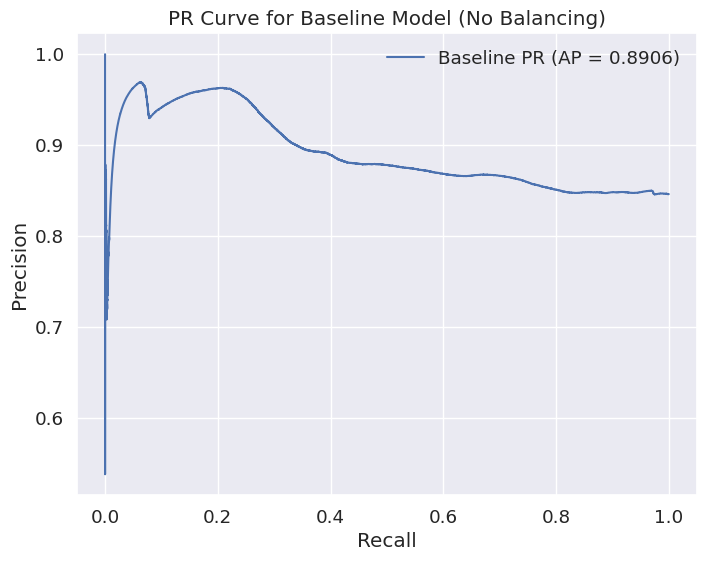

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(recall_baseline, precision_baseline, label=f'Baseline PR (AP = {pr_auc_baseline:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Baseline Model (No Balancing)')
plt.legend()
plt.show()

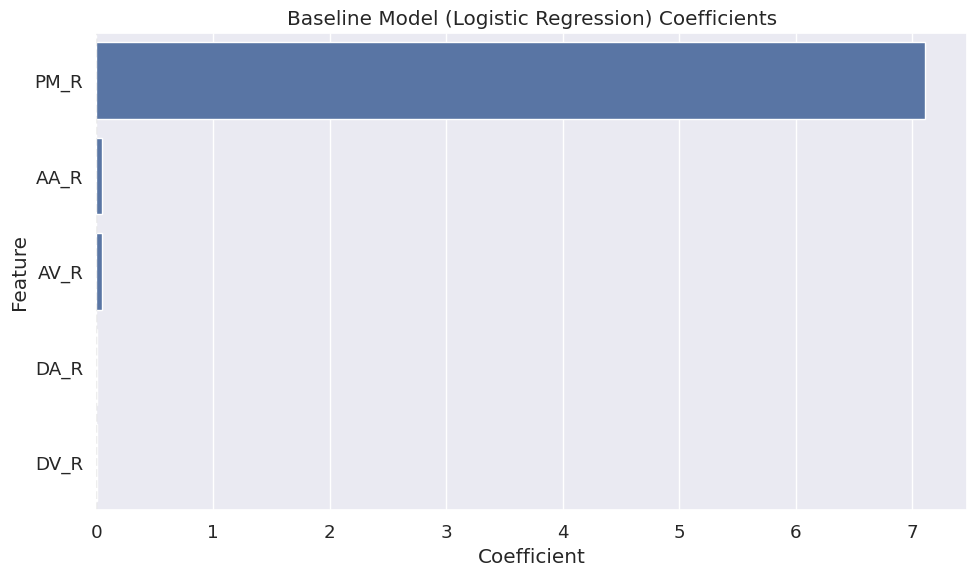

In [43]:
# Feature importance for baseline model
baseline_coef = baseline_model.coef_[0]
baseline_feature_importance = pd.DataFrame({'Feature': ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R'], 
                                          'Coefficient': baseline_coef})
baseline_feature_importance = baseline_feature_importance.sort_values('Coefficient', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=baseline_feature_importance)
plt.title('Baseline Model (Logistic Regression) Coefficients')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [44]:
# Interpretation of baseline coefficients
print("\nInterpretation of baseline model coefficients:")
for feature, coef_value in zip(baseline_feature_importance['Feature'], baseline_feature_importance['Coefficient']):
    effect = "positively" if coef_value > 0 else "negatively"
    print(f"- {feature}: {coef_value:.4f} - {effect} affects the probability of normal welding quality")



Interpretation of baseline model coefficients:
- PM_R: 7.1105 - positively affects the probability of normal welding quality
- AA_R: 0.0514 - positively affects the probability of normal welding quality
- AV_R: 0.0481 - positively affects the probability of normal welding quality
- DA_R: 0.0080 - positively affects the probability of normal welding quality
- DV_R: 0.0080 - positively affects the probability of normal welding quality


In [45]:
# Store baseline results for later comparison
baseline_results = {
    'accuracy': baseline_accuracy,
    'report': baseline_report,
    'conf_matrix': baseline_conf_matrix,
    'fpr': fpr_baseline,
    'tpr': tpr_baseline,
    'roc_auc': roc_auc_baseline,
    'precision': precision_baseline,
    'recall': recall_baseline,
    'pr_auc': pr_auc_baseline,
    'model': baseline_model
}


In [47]:
baseline_results

{'accuracy': 0.8190879725364582,
 'report': {'0': {'precision': 0.21277205040091637,
   'recall': 0.06529285117975306,
   'f1-score': 0.09992267088054332,
   'support': 22759.0},
  '1': {'precision': 0.8491212392016682,
   'recall': 0.9560929251950583,
   'f1-score': 0.8994376683332519,
   'support': 125219.0},
  'accuracy': 0.8190879725364582,
  'macro avg': {'precision': 0.5309466448012923,
   'recall': 0.5106928881874057,
   'f1-score': 0.4996801696068976,
   'support': 147978.0},
  'weighted avg': {'precision': 0.7512508044889654,
   'recall': 0.8190879725364582,
   'f1-score': 0.7764723503331019,
   'support': 147978.0}},
 'conf_matrix': array([[  1486,  21273],
        [  5498, 119721]], dtype=int64),
 'fpr': array([0.00000000e+00, 0.00000000e+00, 4.39386616e-05, ...,
        9.99956061e-01, 1.00000000e+00, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 7.98600851e-06, 2.39580255e-05, ...,
        9.99992014e-01, 9.99992014e-01, 1.00000000e+00]),
 'roc_auc': 0.5880154849936708,